# Absolute Earthquake Location


In this tutorial, we will conduct earthquake location using the **grid search method** and the **iteration method**. We first generate synthetic arrival time on each station from the true earthquake location, this process is called **Forward Modelling**. We then invert the location using the station arrival times, the process is named **Inversion**. 

**Why should we do in this way?**

We can compare the **inverted location** and the **true location** to see:
  1. Whether the location process runs properly;
  2. To conduct error analysis.

**Simplicity**

To present key elements, we simplify two aspects:
1. We use one-layer model to avoid complicated ray-tracing (*Snell's law*).
2. We consider P arrival (*Vp*), S arrival is just with different velocity (*Vs*).
  
### Authors

**ZI, Jinping**, Earth Science Sytem Program, CUHK

**SONG, Zilin**, Earth Science Sytem Program, CUHK

### Testers

**XIA, Zhuoxuan**, Earth Science Sytem Program, CUHK

**SUN, Zhangyu**, Earth Science Sytem Program, CUHK

# Python Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

###### Define useful functions 

In [2]:
def iter_loc(hyc_loop,stas,dobs,V,niter=10,show=True):
    """
    Do iterative earthquake location
    Parameters:
    | hyc_loop: hypoceter for iteration
    |     stas: array contains stations location
    |     dobs: observed travel time
    Return:
    | hyc_loop: earthquake location after iteration
    | sigma_m2: square sigma matrix
    |  sigma_d: root mean square residual
    """
    nobs = dobs.shape[0]
    k = 0
    while k < niter:
        dcal = np.zeros((nobs,1))
        for i in range(dobs.shape[0]):
            dx = stas[i,0]-hyc_loop[0]
            dy = stas[i,1]-hyc_loop[1]
            dz = stas[i,2]-hyc_loop[2]
            dcal[i,0] = np.sqrt(dx**2+dy**2+dz**2)/V+hyc_loop[3]
        delta_d = dobs - dcal
        e2 = 0 
        for i in range(nobs):
            e2 += delta_d[i,0]**2
        if show:
            print(f"Iteration {k} square error: ",format(e2,'5.2f'))

        # >>>>> Build G matrix >>>>>>
        G = np.zeros((nobs,4))
        G[:,3]=1
        for i in range(dobs.shape[0]):
            for j in range(3):
                denomiter = np.sqrt((hyc_loop[0]-stas[i,0])**2+(hyc_loop[1]-stas[i,1])**2+(hyc_loop[2]-stas[i,2])**2)
                G[i,j]=(hyc_loop[j]-stas[i,j])/denomiter/V

        # >>>>> Invert the m value >>>>        
        GTG = np.matmul(G.T,G)
        GTG_inv = np.linalg.inv(GTG)
        GTG_inv_GT = np.matmul(GTG_inv,G.T)
        delta_m = np.matmul(GTG_inv_GT,delta_d)

        # >>>>> Update the hypocenter loop >>>>>
        hyc_loop = np.add(hyc_loop,delta_m.ravel())
        k = k+1

        # >>>>> End the loop if error is small >>>>>
        if e2<0.0000001:
            break
    sigma_d = np.std(delta_d)
    sigma_d2 = sigma_d**2
    sigma_m2 = sigma_d2 * GTG_inv
    return hyc_loop, sigma_m2, sigma_d

def get_init_loc(dobs,stas,depth=5,gap_time=1):
    """
    Get initial earthquake location
    Parameters:
    |    dobs: observed travel time
    |    stas: array contain station location
    |   depth: initial depth of earthquake location
    |gap_time: set event initial gap time before the earliest arrival 
    """
    dmin = np.min(dobs)         # The minimum arrival time
    idx = np.argmin(dobs)       # The index of observation

    hyc_init = np.zeros(4);      # Init array
    hyc_init[0] = stas[idx,0];   # Set the same x,y with station
    hyc_init[1] = stas[idx,1];   # Set the same x,y with station
    hyc_init[2] = depth;             # Set initial depth 5 km
    hyc_init[3] = dmin-gap_time;        # Set initial event time 1s earlier than arrival
    print("Initial trial parameters ","x: ",hyc_init[0],"km; ",
                                      "y: ",hyc_init[1],"km; ",
                                      "z: ",hyc_init[2],"km; ",
                                      "t: ", format(hyc_init[3],'.4f')+" s")
    return hyc_init

def present_loc_results(hyc,sig_square=None,std_fmt='.2f'):
    """
    Print earthquake location results
    Parameters:
    |         hyc: hypocenter
    |sigma_square: squared sigma matrix
    |     std_fmt: format control of the output uncertainty
    """
    _x = format(np.round(hyc[0],4),format("6.2f"))
    _y = format(np.round(hyc[1],4),format("6.2f"))
    _z = format(np.round(hyc[2],4),format("6.2f"))
    _t = format(np.round(hyc[3],4),format("6.2f"))
    if not isinstance(sig_square,np.ndarray):
        print("x = ",_x," km")
        print("x = ",_y," km")
        print("z = ",_z," km")
        print("t = ",_t," s")
    else:
        stdx = sig_square[0,0]**0.5
        _stdx = format(np.round(stdx,4),std_fmt)
        stdy = sig_square[1,1]**0.5
        _stdy = format(np.round(stdy,4),std_fmt)
        stdz = sig_square[2,2]**0.5
        _stdz = format(np.round(stdz,4),std_fmt)
        stdt = sig_square[3,3]**0.5
        _stdt = format(np.round(stdt,4),std_fmt)
        print("x = ",_x,"±",_stdx," km")
        print("y = ",_y,"±",_stdy," km")
        print("z = ",_z,"±",_stdz," km")
        print("t = ",_t,"±",_stdt," s")
        
def matrix_show(*args,**kwargs):
    """
    Show matrix values in grids shape
    Parameters:cmap="cool",gridsize=0.6,fmt='.2f',label_data=True
    """
    ws = []
    H = 0
    str_count = 0
    ndarr_count = 0
    new_args = []
    for arg in args:
        if isinstance(arg,str):
            new_args.append(arg)
            continue
        if isinstance(arg,list):
            arg = np.array(arg)
        if len(arg.shape)>2:
            raise Exception("Only accept 2D array")
        if len(arg.shape) == 1:
            n = arg.shape[0]
            tmp = np.zeros((n,1))
            tmp[:,0] = arg.ravel()
            arg = tmp
        h,w = arg.shape
        if h>H:
            H=h
        ws.append(w)
        new_args.append(arg)
        ndarr_count += 1
    W = np.sum(ws)+len(ws)    # text+matrix+text+...+matrix+text
    if W<0:
        raise Exception("No matrix provided!")
        
    fmt = '.2f'
    grid_size = 0.6
    cmap = 'cool'
    label_data = True
    for arg in kwargs:
        if arg == "fmt":
            fmt = kwargs[arg]
        if arg == 'grid_size':
            grid_size = kwargs[arg]
        if arg == 'cmap':
            cmap = kwargs[arg]
        if arg == 'label_data':
            label_data = kwargs[arg]
    fig = plt.figure(figsize=(W*grid_size,H*grid_size))
    gs = fig.add_gridspec(nrows=H,ncols=W)
    
    wloop = 0
    matrix_id = 0
    for arg in new_args:
        if isinstance(arg,str):
            ax = fig.add_subplot(gs[0:H,wloop-1:wloop])
            ax.axis("off")
            ax.set_xlim(0,1)
            ax.set_ylim(0,H)
            ax.text(0.5,H/2,arg,horizontalalignment='center',verticalalignment='center')
        if isinstance(arg,np.ndarray):
            h,w = arg.shape
            hlow = int(np.round((H-h+0.01)/2))        # Find the height grid range
            hhigh = hlow+h
            wlow = wloop
            whigh = wlow+w
#            print("H: ",H,hlow,hhigh,"; W ",W,wlow,whigh)
            ax = fig.add_subplot(gs[hlow:hhigh,wlow:whigh])
            
            plt.pcolormesh(arg,cmap=cmap)
            for i in range(1,w):
                plt.axvline(i,color='k',linewidth=0.5)
            for j in range(1,h):
                plt.axhline(j,color='k',linewidth=0.5)
            if label_data:
                for i in range(h):
                    for j in range(w):
                        plt.text(j+0.5,i+0.5,format(arg[i,j],fmt),
                                 horizontalalignment='center',
                                 verticalalignment='center')
            plt.xlim(0,w)
            plt.ylim([h,0])
            plt.xticks([])
            plt.yticks([])
            wloop+=w+1
            matrix_id+=1
    plt.show()

# Model Setup
Set up basic parameters:
1. Station locations (stats)

In [43]:
stas_set1 = np.array([[-45,16,0],
                     [-44,10,0],
                     [-12,50,0],
                     [-11,-25,0],
                     [-1,-11,0],
                     [5,-19,0],
                     [20,11,0],
                     [23,-39,0],
                     [35,9,0],
                     [42,-27,0]])
stas = stas_set1     # Use the first station set in tutorial
nsta = stas.shape[0] # number of stations

2. True hypocenter location (hyc_true)
3. Velocity (Vp)

In [44]:
hyc_true = np.array([0.5,0.5,9.45,0])     # The true hypocenter value(x,y,z,t)
Vp = 5                                    # The true wave velocity

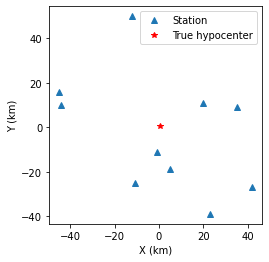

In [45]:
plt.plot(stas[:,0],stas[:,1],'^',label="Station")
plt.plot(hyc_true[0],hyc_true[1],'r*',label='True hypocenter')
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.gca().set_aspect("equal")   # gca: get current axis
plt.legend();

## Generate synthetic arrival time

In [46]:
dobs = np.zeros((nsta,1))            # initiate the parameter
for i in range(dobs.shape[0]):
    dx = stas[i,0]-hyc_true[0]       # x-gap between event and station
    dy = stas[i,1]-hyc_true[1]       # y-gap ...
    dz = stas[i,2]-hyc_true[2]       # z-gap ...
    dobs[i,0] = np.sqrt(dx**2+dy**2+dz**2)/Vp+hyc_true[3] # travel time + event origin time
nobs = dobs.shape[0]                 # number of observations

# The Grid-Search Method
<img src="images/3D_grids.png" width="400"/>
The grid search method separate the possible earthquake location zone into 3-D grids, try each grid as earthquake center and calculate the residual. The grid where earthquake located should be lowest residual. 

### 1.Set up grids

Total number of nodes are:  131220


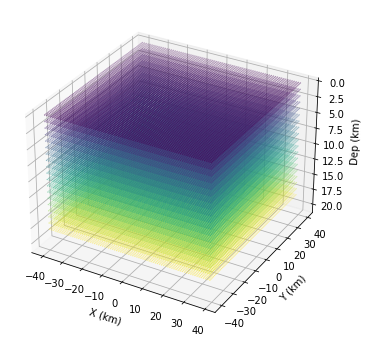

In [55]:
dx = 1                     # offsets of nodes along x direction
dy = 1                     #                        y
dz = 1                     #                        z (depth)    
xs = np.arange(-40,41,dx)  # list of x nodes
ys = np.arange(-40,41,dy)  # list of y nodes
zs = np.arange(0,20,dz)    # list of z nodes
nx = len(xs)               # number of x nodes
ny = len(ys)               # number of y nodes
nz = len(zs)               # number of z nodes
print("Total number of nodes are: ",nx*ny*nz)  # Complete this line
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')     # use 3D plot
nodes = []                         # define arrary to store node information
for x in xs[:-1]:
    for y in ys[:-1]:
        for z in zs[:-1]:
            nodes.append([x,y,z])  # add node to nodes list
nodes = np.array(nodes)            # convert to numpy array
ax.scatter3D(nodes[:,0],nodes[:,1],nodes[:,2],c=nodes[:,2],s=0.1) # c: color, here colored by depth
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Dep (km)")
ax.set_zlim([20,0])
plt.show()

### 2. Try each grid and calculate error

In [56]:
V = 4.9                                   # define the velocity
sq_errs = np.zeros((nx,ny,nz))           # define array to save the misfit of each node
ta = time.time()                         # ta: the time before calculation
for i in range(len(xs)):
    for j in range(len(ys)):
        for k in range(len(zs)):
            dcal = np.zeros((nsta,1))    # for each node (x,y,z), the arrival time could 
            x = xs[i];y=ys[j];z=zs[k]
            for m in range(nsta):        # loop over stations
                sta_x = stas[m,0]
                sta_y = stas[m,1]
                sta_z = stas[m,2]
                dist = np.sqrt((sta_x-x)**2+(sta_y-y)**2+(sta_z-z)**2) # distance between node and station
                dcal[m,0] = dist/V                                     # the travel time
            sq_err = np.linalg.norm(dobs-dcal)**2                      # squared error
            sq_errs[i,j,k] = sq_err                                    # update to the error array
tb = time.time()                                                       # The time after calculation
print("Time for location process: ",format(tb-ta,'.3f'),'s')           # print the output time

Time for location process:  11.941 s


### 3. Find the minimum misfit grid

In [57]:
sq_err_min = np.min(sq_errs)              # Get the min value
sq_err_max = np.max(sq_errs)
kk = np.where(sq_errs==sq_err_min)        # Get the value indexs
idx = kk[0][0]
idy = kk[1][0]
idz = kk[2][0]
print(f"Minimum occurred in x={xs[idx]}, y={ys[idy]}, z={zs[idz]}")

Minimum occurred in x=0, y=1, z=7


In [58]:
hyc_true

array([0.5 , 0.5 , 9.45, 0.  ])

Z=00,min_sq_error= 0.502, x=0, y=1
Z=01,min_sq_error= 0.487, x=0, y=1
Z=02,min_sq_error= 0.445, x=0, y=1
Z=03,min_sq_error= 0.382, x=0, y=1
Z=04,min_sq_error= 0.308, x=0, y=1
Z=05,min_sq_error= 0.236, x=0, y=1
Z=06,min_sq_error= 0.182, x=0, y=1
Z=07,min_sq_error= 0.165, x=0, y=1,global minimum
Z=08,min_sq_error= 0.194, x=1, y=1
Z=09,min_sq_error= 0.269, x=0, y=0
Z=10,min_sq_error= 0.407, x=0, y=0
Z=11,min_sq_error= 0.645, x=1, y=0
Z=12,min_sq_error= 1.016, x=1, y=0
Z=13,min_sq_error= 1.550, x=1, y=0
Z=14,min_sq_error= 2.267, x=1, y=0
Z=15,min_sq_error= 3.122, x=1, y=-1
Z=16,min_sq_error= 4.201, x=1, y=-1
Z=17,min_sq_error= 5.529, x=1, y=-1
Z=18,min_sq_error= 7.127, x=1, y=-1
Z=19,min_sq_error= 9.014, x=1, y=-1


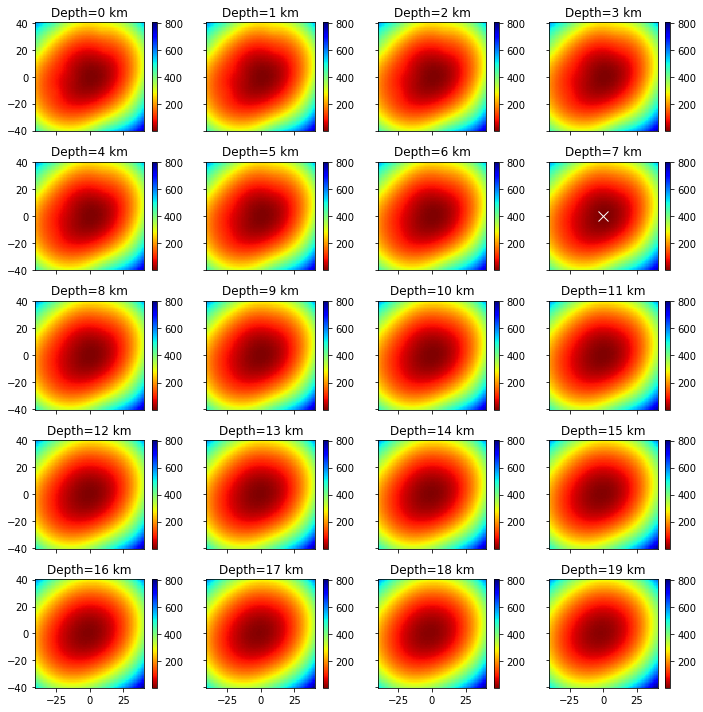

In [59]:
# plot results
ncol = 4
if nz%ncol==0:
    nrow = int(nz/ncol)
else:
    nrow = int(nz/ncol)+1
fig, axs = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2*nrow),sharex=True,sharey=True)
axs = axs.ravel()

xs_mesh,ys_mesh = np.meshgrid(xs,ys)
for i in range(nz):
    pm = axs[i].pcolormesh(xs_mesh,ys_mesh,sq_errs[:,:,i],
                  shading='auto',cmap='jet_r',vmin=sq_err_min,vmax=sq_err_max)
    plt.sca(axs[i])        # set current active axis
    plt.colorbar(pm)
    tmp_sq_err_min = np.min(sq_errs[:,:,i])
    _tmp_sq_err_min = format(tmp_sq_err_min,'6.3f')
    tmp_kk = np.where(sq_errs[:,:,i]==tmp_sq_err_min)
    idx = tmp_kk[0][0]
    idy = tmp_kk[1][0]
    _Z = str(zs[i]).zfill(2)
    if tmp_sq_err_min == sq_err_min:
        print(f"Z={_Z},min_sq_error={_tmp_sq_err_min}, x={xs[idx]}, y={ys[idy]},global minimum")
        axs[i].plot(xs[idx],ys[idx],'wx',ms=10)
    else:
        print(f"Z={_Z},min_sq_error={_tmp_sq_err_min}, x={xs[idx]}, y={ys[idy]}")
    axs[i].set_aspect('equal')
    axs[i].set_title(f"Depth={zs[i]} km")

# adjust plot    
plt.tight_layout()

### Exercise
Modify V = 4.9 and redo the grid search, what do you find?

# Iterative Method
The arrival time recorded by one station could be presented:
$$ T_i^k = O_k+\int_{s}^{r}uds $$
where $T_i^k$ is the arrival time of event k on station i. In the right side of equation, there are two components: 
    1. The origin time $O_k$; 
    2. The travel time. It is the integral over the ray path. $s$: source, $r$ receiver (station), $u$ slowness.
It could be presented as below, note below equation is non-linear:
$$ \mathbf{Fm_{true}=d_{obs}} $$
Using Taylor Expansion, we have:
$$ \mathbf{F(m+\Delta m) = Fm + \frac{\partial F}{\partial m}\Delta m + ...,} $$
where $\mathbf{m} = (x,y,z,t)$. Ingoring high-order component:
$$ \mathbf{\Delta d = \frac{\partial F}{\partial m}\Delta m}$$
It means the misfit of data is related to the misfit of earthquake location, the relationship is presented as:
$$T_i^k = O_k+\int_{s}^{r}uds$$
$$\frac{\partial \mathbf{F}}{\partial \mathbf{m}}=
\frac{\partial T}{\partial x}\Delta x+
\frac{\partial T}{\partial y}\Delta y+
\frac{\partial T}{\partial z}\Delta z+
\frac{\partial T}{\partial t}\Delta t$$
More in detail:
$$\begin{cases}
\frac{\partial T}{\partial x}=dx/ds\cdot u\\
\frac{\partial T}{\partial y}=dy/ds\cdot u\\
\frac{\partial T}{\partial z}=dz/ds\cdot u\\
\frac{\partial T}{\partial t}=1
\end{cases}$$
where $ds=\sqrt{(dx)^2+(dy)^2+(dz)^2}$

For one-layer model, $T_i^k=o_t +\sqrt{x^2+y^2+z^2}/v$, where $x,y,z$ denotes distance between the source (earthquake location) and receiver(station), $v$ is velocity.
Partial derivatives are:
$$\frac{\partial T_i^k}{\partial x} = \frac{x}{\sqrt{x^2+y^2+z^2}v}$$
$$\frac{\partial T_i^k}{\partial y} = \frac{y}{\sqrt{x^2+y^2+z^2}v}$$
$$\frac{\partial T_i^k}{\partial y} = \frac{z}{\sqrt{x^2+y^2+z^2}v}$$
$$\frac{\partial T_i^k}{\partial o_t} = 1$$
$$
\begin{bmatrix}
\frac{\partial T_1}{\partial x}&\frac{\partial T_1}{\partial y}&\frac{\partial T_1}{\partial z}&1\\
\frac{\partial T_2}{\partial x}&\frac{\partial T_2}{\partial y}&\frac{\partial T_2}{\partial z}&1\\
\vdots&\vdots&\vdots&\vdots\\
\frac{\partial T_i}{\partial x}&\frac{\partial T_i}{\partial y}&\frac{\partial T_i}{\partial z}&1\\
\end{bmatrix}
\begin{bmatrix}
\Delta x\\\Delta y \\\Delta z \\\Delta t
\end{bmatrix}=
\begin{bmatrix}
d_1^{obs} - d_1^{cal}\\d_2^{obs} - d_2^{cal}\\\vdots\\d_i^{obs} - d_i^{cal}\\
\end{bmatrix}
$$
After solve this equation, we can update the earthquake location:
$$\mathbf{m=m+\Delta m}$$
This process generally will not finish in one iteration, more iterations are needed until no apparent change of misfit.

## Workflow
<img src="images/Earthquake_location_workflow.jpg" alt="drawing" width="400"/>


### 1. Give an initial source parameters
The station which records the earliest arrival is the cloest to the hypocenter, so it is reasonable to be set as initial location:
1. The same x and y with the closest station;
2. Initial depth at 5 km;
3. Initial origin time 1 sec before the earliest arrival;

In [12]:
idx = np.argmin(dobs)        # The index of station
dmin = np.min(dobs)          # The minimum arrival time

hyc_init = np.zeros(4);      # Init array of hypocenter
hyc_init[:2] = stas[idx,:2]; # Set the same x,y with station
hyc_init[2] = 5;             # Set initial depth 5 km
hyc_init[3] = dmin-1;        # Set initial event time earlier than arrival
hyc_loop = hyc_init.copy()

### 2. Calculate the arrival times based on input location

In [13]:
dcal = np.zeros((nsta,1))
for i in range(dobs.shape[0]):
    dx = stas[i,0]-hyc_loop[0]   # offset between event and station
    dy = stas[i,1]-hyc_loop[1]
    dz = stas[i,2]-hyc_loop[2]
    dcal[i,0] = np.sqrt(dx**2+dy**2+dz**2)/Vp+hyc_loop[3] # arrival time = travel time + origin time

### 3. Measure the misfit between the $d_{obs}$ and the $d_{cal}$

In [14]:
delta_d = dobs - dcal             # travel time difference
e2 = 0 
for i in range(delta_d.shape[0]): # calculate total error
    e2 += delta_d[i,0]**2
print(f"The square error: ",format(e2,'5.6f'))

The square error:  49.466691


### 4. Calculate Partial Derivatives

In [15]:
G = np.zeros((nsta,4))      # nsta rows; 4 columns due to m=(x,y,z,t)
for i in range(nsta):
    for j in range(3):      # loop x,y,z
        denomiter = np.sqrt((hyc_loop[0]-stas[i,0])**2+(hyc_loop[1]-stas[i,1])**2+(hyc_loop[2]-stas[i,2])**2)
        G[i,j]=(hyc_loop[j]-stas[i,j])/denomiter/Vp
G[:,3]=1                    # partial derivative of time is 1

### 5. Estimation of $\Delta m$, generalized inversion problem
Define $\Delta m = (\Delta x, \Delta y, \Delta z,\Delta t)$, the relationship between $\Delta m$ and $\Delta d$ is:
$$G\Delta m =\Delta d$$
$G$ is not a square matrix, $G^TG$ is a square matrix, we then have:
$$G^TG\Delta m=G^T\Delta d$$
If the inverse of $G^TG$ exists (the determinnant != 0, in here we have 10 observations to solve for 4 parameters), then:
$$\Delta m = (G^TG)^{-1}G^T\Delta d$$

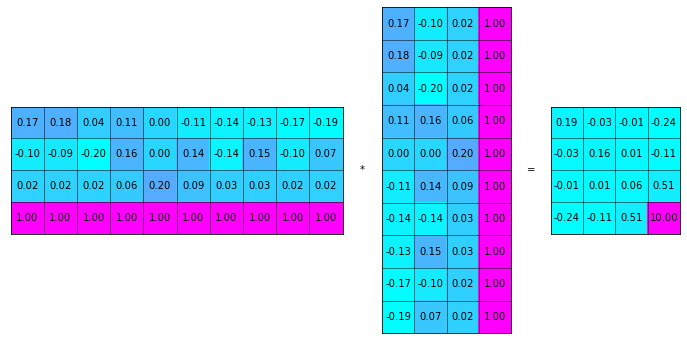

In [16]:
GTG = np.matmul(G.T,G)
matrix_show(G.T,"*",G,"=",GTG)

In [17]:
GTG_inv = np.linalg.inv(GTG)               # calculate inverse
GTG_inv_GT = np.matmul(GTG_inv,G.T)        # inverse of GTG multiply G.T
delta_m = np.matmul(GTG_inv_GT,delta_d)    
print("delta m: ",delta_m.ravel())

delta m:  [ 1.27106047 10.82922813  9.25013738 -1.91360853]


### 6. Update hypocenter

In [18]:
hyc_loop = np.add(hyc_loop,delta_m.ravel())    # m = m + delta m
print("After this run, results (x,y,z,t) are:",hyc_loop)
print("True location parameters(x,y,z,t) are:",hyc_true)

After this run, results (x,y,z,t) are: [ 0.27106047 -0.17077187 14.25013738  0.07839748]
True location parameters(x,y,z,t) are: [0.5  0.5  9.45 0.  ]


### 7. Start new iteration
Move back to step two
<br />
<br />

## Integrated Solution
Group previous steps into a loop function

In [19]:
niter = 10                         # maximum iteration
hyc_loop = hyc_init.copy()         # initiate the hypocenter information

dcal = np.zeros((10,1))            # calculate travel time
for i in range(dobs.shape[0]):
    dx = stas[i,0]-hyc_loop[0]
    dy = stas[i,1]-hyc_loop[1]
    dz = stas[i,2]-hyc_loop[2]
    dcal[i,0] = np.sqrt(dx**2+dy**2+dz**2)/Vp+hyc_loop[3]
delta_d = dobs - dcal
k = 0 
while k < niter:                   # loop start
    # >>>>> Build G matrix >>>>>>
    G = np.zeros((nsta,4))
    G[:,3]=1
    for i in range(nsta):
        for j in range(3):
            denomiter = np.sqrt((hyc_loop[0]-stas[i,0])**2+(hyc_loop[1]-stas[i,1])**2+(hyc_loop[2]-stas[i,2])**2)
            G[i,j]=(hyc_loop[j]-stas[i,j])/denomiter/Vp
    
    # >>>>> Invert the m value >>>>        
    GTG = np.matmul(G.T,G)
    GTG_inv = np.linalg.inv(GTG)
    GTG_inv_GT = np.matmul(GTG_inv,G.T)
    delta_m = np.matmul(GTG_inv_GT,delta_d)
    
    # >>>>> Update the hypocenter loop >>>>>
    hyc_loop = np.add(hyc_loop,delta_m.ravel())
    k = k+1
    dcal = np.zeros((10,1))
    for i in range(dobs.shape[0]):
        dx = stas[i,0]-hyc_loop[0]
        dy = stas[i,1]-hyc_loop[1]
        dz = stas[i,2]-hyc_loop[2]
        dcal[i,0] = np.sqrt(dx**2+dy**2+dz**2)/Vp+hyc_loop[3]
    delta_d = dobs - dcal
    e2 = 0 
    for i in range(delta_d.shape[0]):
        e2 += delta_d[i,0]**2
    print(f"Iteration {k} square error: ",format(e2,'10.8f'))
    
    # >>>>> add codes to end the loop if error is small >>>>>

    
hyc_estimate = hyc_loop    
print(hyc_estimate)

Iteration 1 square error:   1.85
Iteration 2 square error:   0.03
Iteration 3 square error:   0.00
Iteration 4 square error:   0.00
Iteration 5 square error:   0.00
Iteration 6 square error:   0.00
Iteration 7 square error:   0.00
Iteration 8 square error:   0.00
Iteration 9 square error:   0.00
Iteration 10 square error:   0.00
[ 5.00000000e-01  5.00000000e-01  9.45000000e+00 -4.08312821e-16]


#### Exercise (10min)
1. Calculate the time used for the iterative location. Compare it with the grid search method.
2. It is a common practice that if the square error lower than a threshold, finish the iteration in advance. Add one criterion in above codes: if square error lows than 0.0000001, break the iteration.
3. It is common to set up an indicator parameter "istop" to show the stop reason of iteration, if iteration stops due to run over all the iterations, then istop = 0; if the iteration stops due to error threshold achieved, then istop = 1.
4. Try to change parameters, e.g. Vp, hyc_true, what's the maximum iterations needed to converge?

# More Practical Case
In the iterative method case, we first generate the arrival times and then invert for the earthquake location, we find that it is very efficient, fast, and accurate to do so. The error decreases to nearly 0 in around 3 iterations. However, in real cases, it is rare to have error decreased to nearly 0 due to series of factors: 
1. The picking error; 
2. Time - error of stations; 
3. Others.

### Phase-Picking Error
Could you find the P arrival in below waveforms?

<img src="images/GS020_P.png" alt="drawing" width="400"/>
<img src="images/BHT.png" alt="drawing" width="400"/>

**The most advanced machine learning phase-pick method has a standard error of ~0.08s in picking P phases.**

# Error Distribution
It is reasonable to assume the picking errors follow the **Gaussian Distribution**, the probability we pick the phase arrival close to the true arrival is high and the probability that picked phase is far offset the true arrival is weak.
$$\sigma^2=\frac{1}{K}\sum_{i=1}^{K}(d_i-\bar{d})^2$$
$$f(x;\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}exp\bigl(-\frac{(x-\mu)^2}{2\sigma^2}\bigr)$$
<img src="images/Normal_distribution.png" alt="drawing" width="400"/>
(Credit: Wikipedia)

### 1. Generate random normal distribution error in python

Text(0, 0.5, 'Quantity')

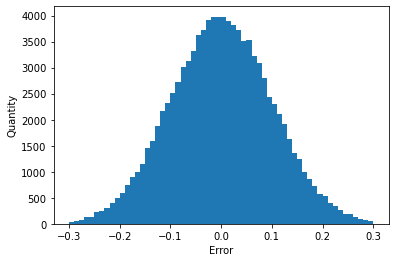

In [20]:
mu = 0
sigma = 0.1
errors = np.random.normal(mu,sigma,size=(100000,1))
bins = np.arange(mu-3*sigma,mu+3*sigma,0.01)
plt.hist(errors,bins=bins);
plt.xlabel("Error")
plt.ylabel("Quantity")

### Generate repeatable random normal distribution noise

In [21]:
print("Below ten sets of random data:")
for i in range(10):
    errors = np.random.normal(mu,sigma,size=(5,1))
    print(errors.ravel())

print("Below ten sets of repeatable random data:")
for i in range(10):
    seed = 5
    np.random.seed(seed)
    errors = np.random.normal(mu,sigma,size=(5,1))
    print(errors.ravel())

Below ten sets of random data:
[-0.00162649 -0.02211802 -0.02262335 -0.0123663  -0.06426477]
[-0.04133508  0.11856804  0.15216861 -0.06263951 -0.1179858 ]
[ 0.23776084 -0.13150854  0.15360653 -0.04888273  0.075115  ]
[ 0.09252408 -0.01553433  0.0766549  -0.17358526 -0.00289097]
[ 0.0651469   0.13470883  0.0159549  -0.08358288  0.14962492]
[-0.07112944  0.00326091 -0.0312847  -0.11113971  0.09118936]
[ 0.01733178  0.14352563  0.09294521  0.15886035 -0.05112859]
[ 0.09772269  0.02389182 -0.04215373 -0.08050762 -0.11466363]
[ 0.1402498  -0.17032456  0.08669463 -0.02554362 -0.18024711]
[-0.03561632  0.05974417 -0.05540375  0.08221637  0.00308235]
Below ten sets of repeatable random data:
[ 0.04412275 -0.03308702  0.24307712 -0.02520921  0.01096098]
[ 0.04412275 -0.03308702  0.24307712 -0.02520921  0.01096098]
[ 0.04412275 -0.03308702  0.24307712 -0.02520921  0.01096098]
[ 0.04412275 -0.03308702  0.24307712 -0.02520921  0.01096098]
[ 0.04412275 -0.03308702  0.24307712 -0.02520921  0.0109609

### 2. Update the observed data by adding noise

In [22]:
mu = 0               # mean of error
sigma = 0.1          # stand deviation of error
np.random.seed(100)  
errors = np.random.normal(mu,sigma,size=(nsta,1)) # mean, sigma, size of errors
dobs_noise = dobs+errors                          # add noise to data

### 3. Re-run the inversion 

In [23]:
Vp = 5                         # Reset Vp
k = 0
niter = 10
hyc_loop = hyc_init.copy()
while k < niter:
    dcal = np.zeros((10,1))
    for i in range(dobs_noise.shape[0]):
        dx = stas[i,0]-hyc_loop[0]
        dy = stas[i,1]-hyc_loop[1]
        dz = stas[i,2]-hyc_loop[2]
        dcal[i,0] = np.sqrt(dx**2+dy**2+dz**2)/Vp+hyc_loop[3]
    delta_d = dobs_noise - dcal
    e2 = 0 
    for i in range(delta_d.shape[0]):
        e2 += delta_d[i,0]**2
    print(f"Iteration {k} square error: ",format(e2,'5.2f'))
    
    # >>>>> Build G matrix >>>>>>
    G = np.zeros((10,4))
    G[:,3]=1
    for i in range(10):
        for j in range(3):
            denomiter = np.sqrt((hyc_loop[0]-stas[i,0])**2+(hyc_loop[1]-stas[i,1])**2+(hyc_loop[2]-stas[i,2])**2)
            G[i,j]=(hyc_loop[j]-stas[i,j])/denomiter/Vp
    
    # >>>>> Invert the m value >>>>        
    GTG = np.matmul(G.T,G)
    GTG_inv = np.linalg.inv(GTG)
    GTG_inv_GT = np.matmul(GTG_inv,G.T)
    delta_m = np.matmul(GTG_inv_GT,delta_d)
    if np.array_equal(delta_m.ravel(),[0,0,0,0]):
        print("Here")
    
    # >>>>> Update the hypocenter loop >>>>>
    hyc_loop = np.add(hyc_loop,delta_m.ravel())
    k = k+1

    # >>>>> End the loop if error is small >>>>>
    if e2<0.000001:
        break
hyc_estimate = hyc_loop
print(hyc_estimate)

Iteration 0 square error:  49.29
Iteration 1 square error:   2.00
Iteration 2 square error:   0.06
Iteration 3 square error:   0.05
Iteration 4 square error:   0.05
Iteration 5 square error:   0.05
Iteration 6 square error:   0.05
Iteration 7 square error:   0.05
Iteration 8 square error:   0.05
Iteration 9 square error:   0.05
[ 0.41088965  0.2642783  11.07742038 -0.0956481 ]


In [24]:
hyc_true

array([0.5 , 0.5 , 9.45, 0.  ])

### Exercise (2min)
1. What do you find from the inversion, compare the results with previous run.
2. Change the sigma value and check the variation of inversion results

## Error analysis
The error in observed data will definitely lead to uncertainties in the estimation of earthquake location parameters. Their relationship could be described as:
$$\sigma_m^2=\sigma_d^2(G^TG)^{-1}$$
(Wanna know how is this relationship derived? Please refer to page 435 of **An Introduction to Seismology, Earthquakes, and Earth Structure (2003)**)

In [25]:
sigma_d = np.std(delta_d)       # standard error
sigma_d2 = sigma_d**2           # squared standard error
sigma_m2 = sigma_d2 * GTG_inv   # squared sigma matrix

In [26]:
def present_loc_results(hyc,sig_square=None,std_fmt='.2f'):
    """
    Print earthquake location results
    """
    _x = format(np.round(hyc[0],4),format("6.2f"))
    _y = format(np.round(hyc[1],4),format("6.2f"))
    _z = format(np.round(hyc[2],4),format("6.2f"))
    _t = format(np.round(hyc[3],4),format("6.2f"))
    if not isinstance(sig_square,np.ndarray):
        print("x = ",_x," km")
        print("x = ",_y," km")
        print("z = ",_z," km")
        print("t = ",_t," s")
    else:
        stdx = sig_square[0,0]**0.5
        _stdx = format(np.round(stdx,4),std_fmt)
        stdy = sig_square[1,1]**0.5
        _stdy = format(np.round(stdy,4),std_fmt)
        stdz = sig_square[2,2]**0.5
        _stdz = format(np.round(stdz,4),std_fmt)
        stdt = sig_square[3,3]**0.5
        _stdt = format(np.round(stdt,4),std_fmt)
        print("x = ",_x,"±",_stdx," km")
        print("y = ",_y,"±",_stdy," km")
        print("z = ",_z,"±",_stdz," km")
        print("t = ",_t,"±",_stdt," s")

In [27]:
present_loc_results(hyc_estimate,sigma_m2)

x =    0.41 ± 0.17  km
y =    0.26 ± 0.20  km
z =   11.08 ± 0.81  km
t =   -0.10 ± 0.06  s


#### Question (2 min)
Test different parameters and see how standard error ($\sigma$) changes,
Which parameter has the largest standard error? which parameter has the minimum standard error? Why?

(hint: Check $(G^TG)^{-1}$, $(G^TG)$ and $G$ values)
<br />
<br />
<br />


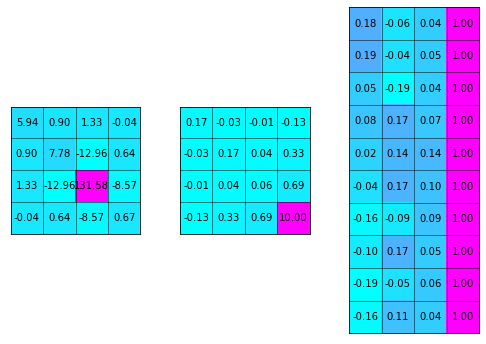

In [28]:
matrix_show(GTG_inv,GTG,G)

## Covariance Matrix
$$\sigma_m^2=\sigma_d^2(G^TG)^{-1}=\begin{bmatrix}
\sigma_{xx}^2&\sigma_{xy}^2&\sigma_{xz}^2&\sigma_{xt}^2\\
\sigma_{yx}^2&\sigma_{yy}^2&\sigma_{yz}^2&\sigma_{yt}^2\\
\sigma_{zx}^2&\sigma_{zy}^2&\sigma_{zz}^2&\sigma_{zt}^2\\
\sigma_{tx}^2&\sigma_{ty}^2&\sigma_{tz}^2&\sigma_{tt}^2\\
\end{bmatrix}$$

From the covariance matrix, we can estiamte the uncertainty of x,y,z,t using $\sigma_x^2$,$\sigma_y^2$,$\sigma_z^2$,$\sigma_t^2$

For two parameters $x$ and $y$, definition of their covariance is as follows,
$$\sigma_{xy}^2 =  \frac{1}{K}\sum_{k=1}^{K}(x^k-\bar{x})(y^k-\bar{y})$$
$$$$

-0.08505250641559049


Text(0.5, 0, 'X')

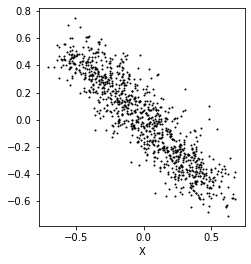

In [29]:
size = 1000
xs = np.zeros((size,1))
delta = 0.5
xs[:,0] = np.linspace(-delta,delta,size)
ys = xs*-1
xs_noise = np.random.normal(0,0.1,(size,1))
ys_noise = np.random.normal(0,0.1,(size,1))
xs = xs+ xs_noise
ys = ys+ ys_noise
total = 0
mean_xs = np.mean(xs)
mean_ys = np.mean(ys)
for i in range(size):
    total += (xs[i,0] - mean_xs)*(ys[i,0]-mean_ys)
sigma_xy2 = total/size
print(sigma_xy2)
plt.plot(xs,ys,'ko',ms=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")

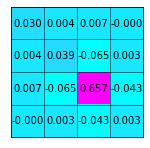

In [30]:
matrix_show(sigma_m2,fmt='.3f')

### Principle axes
Note that off-diagonal elements of $\sigma_m^2$ is not zero. Using **xy plane** as an example, its shape could be presented by the figure below generated. The principle axes are not along the same direction with **xy** axis.

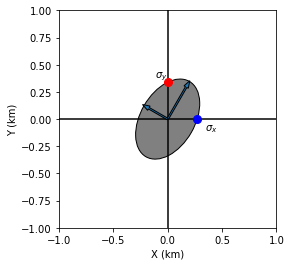

In [31]:
angle = 30
width = 0.5
height = 0.8
ellipse = Ellipse(xy=[0,0],width=0.5,height=0.8,angle=-angle)
ellipse.set_facecolor('grey')
ellipse.set_edgecolor('black')
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.add_artist(ellipse)

plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot([-1,1],[0,0],'k')
plt.plot([0,0],[-1,1],'k')
plt.arrow(0,0,height/2*np.sin(np.deg2rad(angle))*0.85,height/2*np.cos(np.deg2rad(angle))*0.85,width=0.015,zorder=10)
plt.arrow(0,0,-width/2*np.cos(np.deg2rad(angle))*0.80,width/2*np.sin(np.deg2rad(angle))*0.80,width=0.015,zorder=10)
plt.plot(0.27,0,'o',color='blue',ms=8)
plt.plot(0,0.34,'o',color='red',ms=8)
plt.text(0.34,-0.1,'$\sigma_x$')
plt.text(-0.12,0.38,'$\sigma_y$')
plt.show()

## Singular Value Decomposition (SVD)
**SVD** could be used to find the principle axes and principle values.
$$M=USV^T$$
$S$ is the ordered eigenvalues array. $V$ is the corresponding eigenvectors.
Below demonstrate the decomposition of errors in xy-plane.

In [32]:
sigma_xy2 = sigma_m2[:2,:2]            # get the x and y component
u,s,vt = np.linalg.svd(sigma_xy2)      # conduct SVD
print("Maximum eigenvalue: ",format(s[0],'.5f')," corresponding eigenvector: ",vt[0,:])
print("Minimum eigenvalue: ",format(s[-1],'.5f')," corresponding eigenvector: ",vt[-1,:])
print("The maximum/minimum eigenvalue ratio: ",format(s[0]/s[1],'.2f'))

Maximum eigenvalue:  0.04066  corresponding eigenvector:  [0.37746731 0.92602291]
Minimum eigenvalue:  0.02783  corresponding eigenvector:  [ 0.92602291 -0.37746731]
The maximum/minimum eigenvalue ratio:  1.46


### Plot the error ellipse and stations
Note: the sigma values are small to be shown, here amplify the size by parameter **size_ratio**

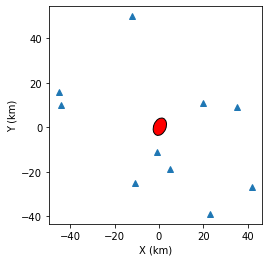

In [33]:
angle = np.arctan(vt[0,0]/vt[0,1])/np.pi*180
size_ratio = 200
ellipse = Ellipse(xy=[hyc_estimate[0],hyc_estimate[1]],width=s[1]*size_ratio,height=s[0]*size_ratio,angle=-angle)
ellipse.set_facecolor('red')
ellipse.set_edgecolor('black')
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.add_artist(ellipse)

plt.plot(stas[:,0],stas[:,1],'^',label="Station")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.show()

# Summary
### One layer model
In the tutorial, we introduced the grid-search method and iterative location method using the one-layer velocity model. The advantage of one-layer is that the ray from the source to one station is a stright line, it is thus convenient to calculate the corresponding partial derivatives. 
In the real earth, however, the velocity varies due to material, pressure and other fators, the ray path is therefore a curved line, making things more complicated.
![image](images/Ray.png)
However, the key process in finding the earthquake locations remains the same.

### The grid search method and the iteraive method
In this tutorial, using the iterative method, we can converge the minimum error location in limited iterations with the random initial location we set. However, in practical cases, due to the complexity of station coverage, velocity structure, and other factors, a random initiation might lead to local minimum rather than global minimum. 
<img src="images/Local_minimum.png" alt="drawing" width="400"/>
(Image courtesy of https://medium.com/analytics-vidhya/journey-of-gradient-descent-from-local-to-global-c851eba3d367)

The general solution is to **conduct rough grid-search first**, which could **avoid local minimum** effectively. Then run the iterative method from the grid search minimum.

## Convenient functions
Defined in the begining of the tutorial

In [34]:
hyc_abs, sigma_m2, sigma_d = iter_loc(hyc_init,stas,dobs,Vp)
present_loc_results(hyc_abs,sigma_m2,std_fmt='.3f')

Iteration 0 square error:  49.47
Iteration 1 square error:   1.85
Iteration 2 square error:   0.03
Iteration 3 square error:   0.00
Iteration 4 square error:   0.00
x =    0.50 ± 0.000  km
y =    0.50 ± 0.000  km
z =    9.45 ± 0.000  km
t =   -0.00 ± 0.000  s


## Play around new station dataset

In [35]:
stas_set2 = np.array([[-45,36,0],
                 [-44,30,0],
                 [-12,50,0],
                 [8,-40,0],
                 [-1,-11,0],
                 [20,-19,0],
                 [20,0,0],
                 [23,-39,0],
                 [35,-5,0],
                 [42,-27,0]])
stas = stas_set2

## Homework

1. Using the second station dataset (stats_set2), run the inversion with noise parameters (seed=100, mu=0,sigma=0.1), plot the error ellipse and stations, could you conclude relationship between the error ellipse and the stations coverage? Show your codes and results(30 Points)
2. In order to enhance the Z constraint, you can change the location of one station in station dataset1, what's your plan and why? Show your codes and results (20 points)
3. In previous example, we calculate the $\sigma_d^2=\frac{1}{nobs}\sum_{i=1}^{nobs}({d_i}-\bar{d})^2$, note it is the sum of square error divided by $nobs$ (number of observations). There are scientists proposed that the calculation should be $\sigma_d^2=\frac{1}{nobs-k}\sum_{i=1}^{nobs}({d_i}-\bar{d})^2$, where $nobs-k$ is called **the number of degrees of freedom**, $k$ is the number of parameters determined by the data, in earthquake location process, $k=4$ for four paramters (x,y,z,t) are inverted. Try to run the inversion 100 times with random noise $\sigma_{true}=0.1s$, calculate the data standard error using two methods, conclude which one is more consistent with the input noise level. Show your codes and results (30 points)
4. What's your comments and suggestions to this tutorial (10 points)